# Data-Driven Control Strategies

This notebook describes how NeqSim's thermodynamic predictions can be combined with plant data to enable data-driven process control.

- [Control theory (Wikipedia)](https://en.wikipedia.org/wiki/Control_theory)
- [Kalman filter (Wikipedia)](https://en.wikipedia.org/wiki/Kalman_filter)
- [Model predictive control (Wikipedia)](https://en.wikipedia.org/wiki/Model_predictive_control)
- [Kalman Filter video](https://www.youtube.com/watch?v=FdJc1_IBKJA)
- [Model Predictive Control video](https://www.youtube.com/watch?v=3F6p19L-9N8)


## Birth of Data-Driven Control

Modern control theory emerged in the mid-20th century with the development of state-space methods and stochastic estimation. Researchers like Rudolf E. Kálmán laid the foundation for combining models and measurements to obtain optimal control policies.


## State Estimation with the Kalman Filter

Given a linear system

$$x_{k+1} = A x_k + B u_k + w_k$$
$$y_k = C x_k + v_k$$

the Kalman filter recursively updates the state estimate:

$$\hat{x}_{k|k-1} = A\hat{x}_{k-1|k-1} + B u_{k-1}$$
$$K_k = P_{k|k-1}C^T(CP_{k|k-1}C^T + R)^{-1}$$
$$\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k(y_k - C\hat{x}_{k|k-1})$$


## Model Predictive Control

At each time step MPC solves

$$\min_{u_0,\dots,u_{N-1}} \sum_{i=0}^{N-1} \left\|x_{k+i} - x^{ref}_{k+i}\right\|_Q^2 + \|u_{k+i}\|_R^2$$

subject to process dynamics and constraints. NeqSim simulations provide predictions \(x_{k+i}\) that improve this optimization.


In [1]:
%%capture
!pip install neqsim matplotlib


## Example: Kalman Filter with NeqSim

The following example builds a simple separator process in NeqSim and applies a scalar Kalman filter to fuse model predictions with noisy measurements.


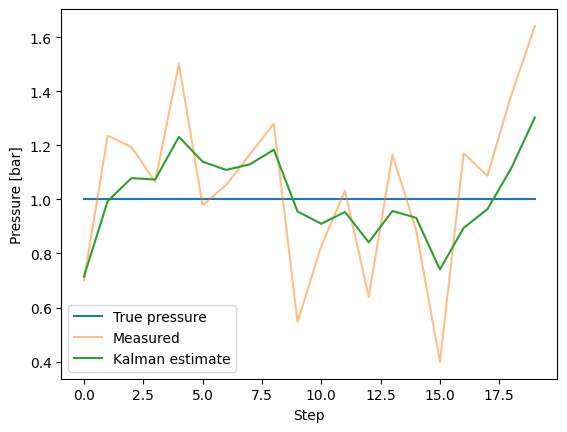

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neqsim import jneqsim

# Build a simple valve and pressure transmitter
fluid = jneqsim.thermo.system.SystemSrkEos(298.15, 10.0)
fluid.addComponent("methane", 0.9)
fluid.addComponent("ethane", 0.1)
fluid.addComponent("n-heptane", 1.0)
fluid.setMixingRule('classic')
feed = jneqsim.process.equipment.stream.Stream("Feed", fluid)
feed.setFlowRate(50.0, "kg/hr")
feed.setPressure(10.0, "bara")
valve = jneqsim.process.equipment.valve.ThrottlingValve("valve", feed)
valve.setOutletPressure(1.0)
valve.setCalculateSteadyState(False)
trans = jneqsim.process.measurementdevice.PressureTransmitter(valve.getOutletStream())
trans.setUnit("bar")
process = jneqsim.process.processmodel.ProcessSystem()
process.add(feed); process.add(valve); process.add(trans)

press_true=[]; press_est=[]; press_meas=[]
x_hat=1.0; P=1.0; Q=0.01; R=0.05
for k in range(20):
    valve.setPercentValveOpening(40 + 20*np.sin(0.3*k))
    process.run()
    p_true = trans.getMeasuredValue()
    y = p_true + np.random.normal(0, np.sqrt(R))
    # Kalman update
    P = P + Q
    K = P/(P + R)
    x_hat = x_hat + K*(y - x_hat)
    P = (1-K)*P
    press_true.append(p_true)
    press_meas.append(y)
    press_est.append(x_hat)

plt.plot(press_true, label='True pressure')
plt.plot(press_meas, label='Measured', alpha=0.5)
plt.plot(press_est, label='Kalman estimate')
plt.ylabel('Pressure [bar]')
plt.xlabel('Step')
plt.legend()
plt.show()


## Example: Simple MPC for Valve Position

NeqSim predictions can evaluate candidate valve openings. The controller below selects an opening that keeps pressure near a target while avoiding large moves.


In [3]:
import numpy as np
target=2.0
current=valve.getPercentValveOpening()
candidates=np.linspace(20,80,7)
best_u=current
best_cost=1e9
for u in candidates:
    valve.setPercentValveOpening(float(u))
    process.run()
    p_pred=trans.getMeasuredValue()
    cost=(p_pred-target)**2 + 0.01*(u-current)**2
    if cost<best_cost:
        best_cost=cost
        best_u=u
valve.setPercentValveOpening(float(best_u))
process.run()
print(f'Chosen valve opening {best_u:.1f}% giving pressure {trans.getMeasuredValue():.2f} bar')


Chosen valve opening 30.0% giving pressure 1.00 bar
